In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

In [22]:
circuit = 'R1-p(CPE2,R2-Wo3)-W1'

initial_guess = [
    0.1,      # R1
    1e-5,     # CPE2_T
    0.9,      # CPE2_P
    200,      # R2
    1.0,      # Wd3_R
    1e-5,     # Wd3_T    # W1_R
    1e-5      # W1_T
]
circuit_model = CustomCircuit(initial_guess=initial_guess, circuit=circuit)

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def load_eis_data_filewise(base_path, circuit_model, soc_value=50, save_csv_path="fitted_params_filewise.csv"):
    fig, ax = plt.subplots(figsize=(10, 8))
    params_list = []

    for batch in range(1, 12):  # B01 to B11
        folder_name = f'B{batch:02d}'

        for i in range(1, 3):  # Test_1 and Test_2
            folder_path = os.path.join(base_path, folder_name, 'EIS measurements', f'Test_{i}', 'Hioki')
            if not os.path.isdir(folder_path):
                print(f"Warning: Folder {folder_path} does not exist. Skipping.")
                continue

            soc_keyword = f"SoC_{soc_value}"
            try:
                all_files = os.listdir(folder_path)
            except Exception as e:
                print(f"Error reading folder {folder_path}: {e}")
                continue

            matched_files = [
                os.path.join(folder_path, fname)
                for fname in all_files
                if soc_keyword in fname and fname.endswith('.csv')
            ]

            if not matched_files:
                print(f"No CSV files found for SoC = {soc_value} in {folder_path}")
                continue

            for file_path in matched_files:
                try:
                    df = pd.read_csv(file_path)
                    df.rename(columns={
                        df.columns[0]: 'frequency',
                        df.columns[1]: 'real impedance',
                        df.columns[2]: 'imaginary impedance'
                    }, inplace=True)

                    freq = df['frequency'].values
                    Z_re = df['real impedance'].values
                    Z_im = df['imaginary impedance'].values
                    Z = Z_re + 1j * Z_im

                    # Fit circuit model
                    circuit_model.fit(freq, Z)
                    fitted_params = circuit_model.parameters_
                    print(f"Fitted parameters for {file_path}: {fitted_params}")

                    # Store with full file context
                    param_dict = {
                        "batch": folder_name,
                        "test": f"Test_{i}",
                        "filename": os.path.basename(file_path)
                    }

                    param_cols = ["R1", "CPE1_T", "CPE1_P", "R2", "Wo3_R", "Wo3_T", "W1_R"]
                    param_dict.update(dict(zip(param_cols, fitted_params)))
                    params_list.append(param_dict)

                    # Nyquist plot
                    ax.plot(Z_re, -Z_im, label=f'{folder_name} T{i}', marker='o', linewidth=1)

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

    # Save fitted parameters to CSV
    if params_list:
        params_df = pd.DataFrame(params_list)
        save_csv_path = os.path.join(base_path, save_csv_path)
        params_df.to_csv(save_csv_path, index=False)
        print(f"\nFitted parameters saved to {save_csv_path}")

    # Final plot setup
    ax.set_xlabel("Z_real (Ohm)")
    ax.set_ylabel("-Z_imag (Ohm)")
    ax.set_title(f"Nyquist Plot (SoC = {soc_value}%)")
    ax.legend(fontsize=8)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

Fitted parameters for /Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/ECM_ML_pipeline/data/B01/EIS measurements/Test_1/Hioki/Hk_IFR14500_SoC_50_03-07-2023_20-49.csv: [5.19067242e-02 1.16294022e+00 4.78512086e-01 3.25945840e-02
 6.63673722e-01 9.47930443e+02 6.90386587e-06]
Fitted parameters for /Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/ECM_ML_pipeline/data/B01/EIS measurements/Test_2/Hioki/Hk_IFR14500_SoC_50_07-06-2023_21-04.csv: [5.03904489e-02 1.10215468e+00 4.83148284e-01 3.29945051e-02
 8.39665927e-13 7.59866783e+02 1.53375016e-02]
Fitted parameters for /Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/ECM_ML_pipeline/data/B02/EIS measurements/Test_1/Hioki/Hk_IFR14500_SoC_50_28-04-2023_02-00.csv: [3.48815154e-02 3.52516345e+00 2.86108983e-01 4.35691657e-02
 1.37697479e+00 2.85188671e+03 4.15417583e-35]
Fitted parameters for /Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/ECM_ML_pipeline/data/B02/EIS measurements/Test_2/Hioki/Hk_IFR14500_SoC_50_29-06-

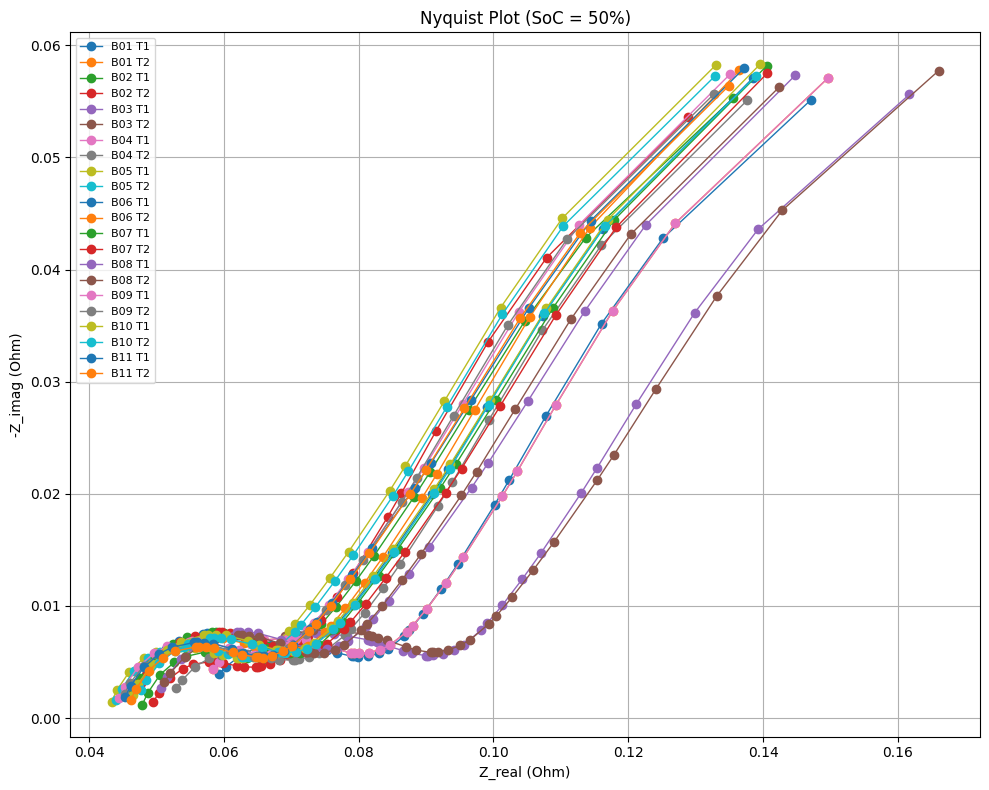

In [50]:
load_eis_data_filewise('/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/ECM_ML_pipeline/data',circuit_model)